In [122]:
%matplotlib inline

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

In [154]:
# Battery class definition
class Battery():
    def __init__(self, k, c, C):
        """
            inputs:
                k : valve conductance
                c : percentace of total capacity in available-charge well
                C : total capacity
        """
        assert 0.0 < c <= 1.0
        self.k = k
        self.c = c
        self.C = C
        self.set_charge_empty()

    def set_charge_full(self):
        self.y1 = self.C * self.c
        self.y2 = self.C * (1-self.c)

    def set_charge_empty(self):
        self.y1 = 0
        self.y2 = 0

    def discharge_step(self, i_t, t, dt):
        y1 = self.y1
        y2 = self.y2
        if y1 == 0:
            return y1, y2, True

        if y2 > 0:
            r = self.k * (y2/(1-self.c) - y1/self.c)
        else:
            r = 0
        dy1 = (-i_t + r) * dt
        new_y1 = y1 + dy1

        dy2 = (-self.k * (y2/(1-self.c) - y1/self.c)) * dt
        new_y2 = y2 + dy2

        new_y1 = 0 if new_y1 < 0 else new_y1
        new_y2 = 0 if new_y2 < 0 else new_y2

        self.y1 = new_y1
        self.y2 = new_y2
        return new_y1, new_y2, False
    
    def charge_step(self, i_ch, t, dt):
        qmax1 = self.C * self.c
        qmax2 = self.C * (1-self.c)
        y1 = self.y1
        y2 = self.y2

        r = self.k * (y1/self.c - y2/(1-self.c))
        if self.y1 == qmax1:
            # constant voltage phase
            dy1 = 0
            dy2 = r * dt
        else:
            # constant current phase           
            dy1 = (i_ch - r) * dt
            dy2 = r * dt

        new_y1 = y1 + dy1
        new_y2 = y2 + dy2
        is_full = False
        # print(new_y1, new_y2, qmax1, qmax2)
        if new_y1 >= qmax1 and new_y2 >= qmax2:
            is_full = True
        
        if new_y1 > qmax1:
            new_y1 = qmax1
        if new_y2 > qmax2:
            new_y2 = qmax2

        self.y1 = new_y1
        self.y2 = new_y2
        
        return new_y1, new_y2, is_full
        
    def simulate_discharge(self, begin_time, end_time, dt, i_t, simulation_name="", plot_history=True, verbose=0):
        y1_history = []
        y2_history = []
        timesteps = []
        lifetime = None
        for t in np.arange(begin_time, end_time + dt, dt):
            if verbose >= 2:
                print(battery)
            
            i_t_value = i_t(t)
            y1, y2, is_empty = battery.discharge_step(i_t_value, t, dt)
            y1_history.append(y1)
            y2_history.append(y2)
            timesteps.append(t)
            if is_empty and lifetime is None:
                lifetime = t
        if plot_history:
            plt.plot(timesteps, y1_history, label="y1")
            plt.plot(timesteps, y2_history, label="y2")
            if lifetime is not None:
                plt.axvline(x=lifetime, linestyle=':', color='k')
                #locs, labels = plt.xticks()
                #new_locs = list(locs)
                #new_locs.append(lifetime)
                #new_locs = list(filter(lambda x: x>=0, new_locs))
                #new_locs.sort()
                #plt.xticks(new_locs, rotation=70)
            if len(simulation_name) > 0:
                plt.title(simulation_name)
            plt.legend()
            plt.xlabel('time (seconds)')
            plt.show()
        if verbose >= 1:
            print(f"lifetime: {lifetime}, battery state at {t}: [{self}]")
        return lifetime, timesteps, y1_history, y2_history

    def simulate_charge(self, begin_time, end_time, dt, i_ch, simulation_name="", plot_history=True, verbose=0):
        y1_history = []
        y2_history = []
        timesteps = []
        charge_time = None
        is_full = False
        
        for t in np.arange(begin_time, end_time + dt, dt):
            if verbose >= 2:
                print(battery)
            y1, y2, is_full = self.charge_step(i_ch, t, dt)
            y1_history.append(y1)
            y2_history.append(y2)
            timesteps.append(t)
            if is_full and charge_time is None:
                charge_time = t
        if plot_history:
            plt.plot(timesteps, y1_history, label="y1")
            plt.plot(timesteps, y2_history, label="y2")
            if charge_time is not None:
                plt.axvline(x=charge_time, linestyle=':', color='k')
            if len(simulation_name) > 0:
                plt.title(simulation_name)
            plt.legend()
            plt.xlabel('time (seconds)')
            plt.show()
        if verbose >= 1:
            print(f"charge time: {charge_time}, battery state at {t}: [{self}]")
        
        return charge_time, y1_history, y2_history, timesteps
    
    def __str__(self):
        return "k:{},c:{},C:{},y1:{:.4f},y2:{:.4f}".format(self.k, self.c, self.C, self.y1, self.y2)

In [117]:
dt = 0.01 # time step in seconds

i_t_constant = lambda t:50 # mA constant current
i_t_linear = (lambda t: (t)) # linearly increasing current
i_t_quad = (lambda t: (t*t)) # quadraticly increasing current

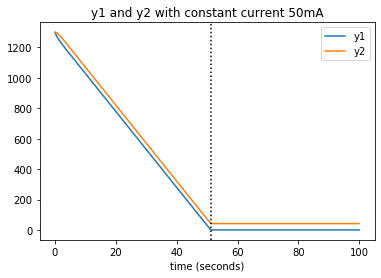

lifetime: 51.17, battery state at 100.0: [k:0.3,c:0.5,C:2600,y1:0.0000,y2:41.5833]


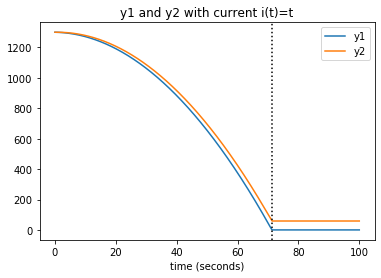

lifetime: 71.3, battery state at 100.0: [k:0.3,c:0.5,C:2600,y1:0.0000,y2:58.6169]


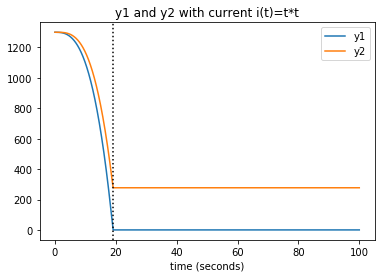

lifetime: 19.11, battery state at 100.0: [k:0.3,c:0.5,C:2600,y1:0.0000,y2:277.2438]


In [127]:

battery = Battery(k=0.3, c=0.5, C=2600)

battery.set_charge_full()
lifetime, timesteps, y1_history, y2_history = battery.simulate_discharge(0, 100, dt, i_t_constant, 
                                                                         simulation_name="y1 and y2 with constant current 50mA",
                                                                         verbose=1)

battery.set_charge_full()
lifetime, timesteps, y1_history, y2_history = battery.simulate_discharge(0, 100, dt, i_t_linear, 
                                                                         "y1 and y2 with current i(t)=t", verbose=1)


battery.set_charge_full()
lifetime, timesteps, y1_history, y2_history = battery.simulate_discharge(0, 100, dt, i_t_quad, 
                                                                         "y1 and y2 with current i(t)=t*t", verbose=1)

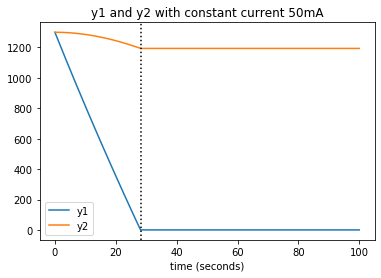

lifetime: 28.13, batter state at 100.0: [k:0.003,c:0.5,C:2600,y1:0.0000,y2:1193.6360]


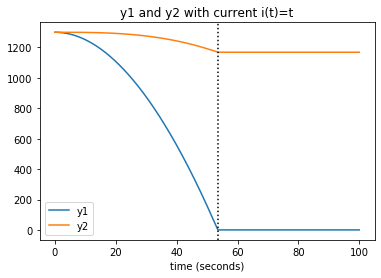

lifetime: 53.52, batter state at 100.0: [k:0.003,c:0.5,C:2600,y1:0.0000,y2:1168.5235]


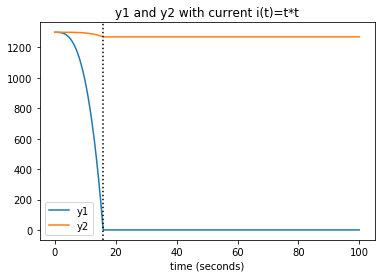

lifetime: 15.870000000000001, batter state at 100.0: [k:0.003,c:0.5,C:2600,y1:0.0000,y2:1269.5292]


In [118]:
battery = Battery(k=0.003, c=0.5, C=2600)

battery.set_charge_full()
lifetime, timesteps, y1_history, y2_history = battery.simulate_discharge(0, 100, dt, i_t_constant, 
                                                                         simulation_name="y1 and y2 with constant current 50mA",
                                                                         verbose=1)

battery.set_charge_full()
lifetime, timesteps, y1_history, y2_history = battery.simulate_discharge(0, 100, dt, i_t_linear, 
                                                                         "y1 and y2 with current i(t)=t", verbose=1)


battery.set_charge_full()
lifetime, timesteps, y1_history, y2_history = battery.simulate_discharge(0, 100, dt, i_t_quad, 
                                                                         "y1 and y2 with current i(t)=t*t", verbose=1)

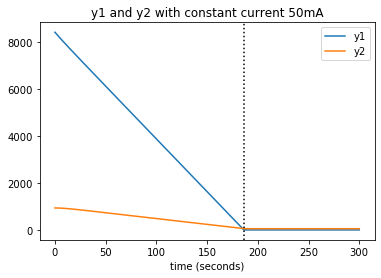

lifetime: 186.16, battery state at 300.0: [k:0.0096,c:0.9,C:9360,y1:0.0000,y2:52.0750]


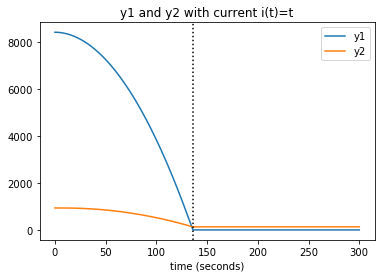

lifetime: 135.86, battery state at 300.0: [k:0.0096,c:0.9,C:9360,y1:0.0000,y2:131.7506]


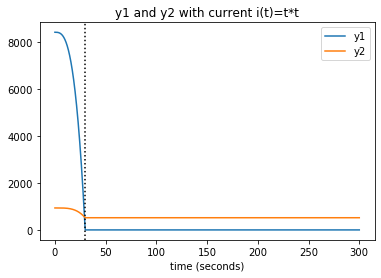

lifetime: 29.830000000000002, battery state at 300.0: [k:0.0096,c:0.9,C:9360,y1:0.0000,y2:519.3994]


In [130]:
battery = Battery(k=9.6e-3, c=0.9, C=9360)

battery.set_charge_full()
lifetime, timesteps, y1_history, y2_history = battery.simulate_discharge(0, 5*60, dt, i_t_constant, 
                                                                         simulation_name="y1 and y2 with constant current 50mA",
                                                                         verbose=1)

battery.set_charge_full()
lifetime, timesteps, y1_history, y2_history = battery.simulate_discharge(0, 5*60, dt, i_t_linear, 
                                                                         "y1 and y2 with current i(t)=t", verbose=1)


battery.set_charge_full()
lifetime, timesteps, y1_history, y2_history = battery.simulate_discharge(0, 5*60, dt, i_t_quad, 
                                                                         "y1 and y2 with current i(t)=t*t", verbose=1)

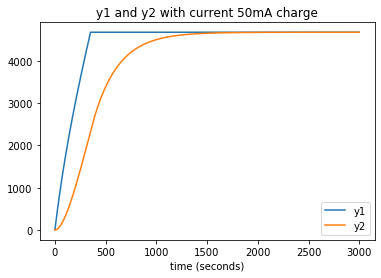

charge time: None, battery state at 3000.0: [k:0.002,c:0.5,C:9360,y1:4680.0000,y2:4679.9414]


In [164]:
battery = Battery(k=0.002, c=0.5, C=9360)
battery.set_charge_empty()
charge_time, timesteps, y1_history, y2_history = battery.simulate_charge(0, 50*60, dt, 20, 
                                                                         "y1 and y2 with current 50mA charge", verbose=1)